<a href="https://colab.research.google.com/github/diego411/coin_seminar/blob/main/cat_sound_type_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resource

https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-pytorch/1-introduction

# Configurations

In [ ]:
data_path = '/content/drive/MyDrive/COIN Seminar/data'
notebook_path = '/content/drive/MyDrive/COIN Seminar/notebooks'

use_mffc = False

spectrogram_path_model1 = f'{data_path}/spectrograms_model1'
spectrogram_path_model2 = f'{data_path}/spectrograms_model2'
mfccs_path_model1 = f'{data_path}/mfccs_model1'
mfccs_path_model2 = f'{data_path}/mfccs_model2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
# util
import os
import sys
import time
from pathlib import Path
from itertools import chain
import numpy as np

# pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# sklearn
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

# Load audio data

In [ ]:
from typing import List

def load_audio_files(paths: List[str], label:str):

    dataset = []

    for path in paths:
      walker_wav = sorted(str(p) for p in Path(path).glob(f'*.wav'))
      walker_mp3 = sorted(str(p) for p in Path(path).glob(f'*.mp3'))

      for i, file_path in enumerate(list(chain(walker_wav, walker_mp3))):
          path, filename = os.path.split(file_path)

          # Load audio
          waveform, sample_rate = torchaudio.load(file_path)
          dataset.append([waveform, sample_rate, label])

    return dataset

In [ ]:
# Meow
base_meow_path = f'{data_path}/Meowing'

trainset_meow_angry = load_audio_files([f'{base_meow_path}/AngryV2'], 'meow_angry')
trainloader_meow_angry = torch.utils.data.DataLoader(trainset_meow_angry, batch_size=1,shuffle=True, num_workers=0)

trainset_meow_happy = load_audio_files([f'{base_meow_path}/Happy'], 'meow_happy')
trainloader_meow_happy = torch.utils.data.DataLoader(trainset_meow_happy, batch_size=1,shuffle=True, num_workers=0)

trainset_meow_sad = load_audio_files([f'{base_meow_path}/Sad'], 'meow_sad')
trainloader_meow_sad = torch.utils.data.DataLoader(trainset_meow_sad, batch_size=1,shuffle=True, num_workers=0)

#trainset_meow_scared = load_audio_files([f'{base_meow_path}/Scared'], 'meow_scared')
#trainloader_meow_scared = torch.utils.data.DataLoader(trainset_meow_scared, batch_size=1,shuffle=True, num_workers=0)

In [ ]:
# Meow
trainset_meow = trainset_meow_angry + trainset_meow_happy + trainset_meow_sad #+ trainset_meow_scared
trainloader_meow = torch.utils.data.DataLoader(trainset_meow, batch_size=1,shuffle=True, num_workers=0)

# Purr
trainset_purr = load_audio_files([f'{data_path}/Purring'], 'purr')
trainloader_purr = torch.utils.data.DataLoader(trainset_purr, batch_size=1,shuffle=True, num_workers=0)

# Hiss
trainset_hiss = load_audio_files([f'{data_path}/Hissing'], 'hiss')
trainloader_hiss = torch.utils.data.DataLoader(trainset_hiss, batch_size=1,shuffle=True, num_workers=0)

# Chirp
trainset_chirp = load_audio_files([f'{data_path}/Chirping'], 'chirp')
trainloader_chirp = torch.utils.data.DataLoader(trainset_purr, batch_size=1,shuffle=True, num_workers=0)

# Create spectrograms

In [ ]:
def create_spectrogram_images(trainloader, spectrogram_path, label_dir):
    directory = f'{spectrogram_path}/{label_dir}'

    if not os.path.isdir(directory):
        os.makedirs(directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(trainloader):

      # this is probably not the best solution it would be better to remove these passages in the audio that create 0 values
      # apply very small offset so no zeros are in the waveform since the log(0) = -inf and -inf causes
      # problems when saving the spectrogram
      waveform = data[0] + 1e-9

      # create transformed waveforms
      spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)
      spectrogram_numpy = spectrogram_tensor.log2()[0,:,:].numpy()
      filter = spectrogram_numpy != np.NINF
      filtered_spectrogram = np.where(filter, spectrogram_numpy, sys.float_info.min) # replace remaining -inf with smallest float

      plt.figure()
      plt.imsave(f'{directory}/spec_img{i}.png', filtered_spectrogram, cmap='viridis')
      plt.close()

In [ ]:
# Spectrograms for first model
create_spectrogram_images(trainset_meow, spectrogram_path_model1, 'meow')
create_spectrogram_images(trainset_purr, spectrogram_path_model1, 'purr')
create_spectrogram_images(trainset_hiss, spectrogram_path_model1, 'hiss')
create_spectrogram_images(trainset_chirp, spectrogram_path_model1, 'chirp')

In [ ]:
# Spectrograms for second model
create_spectrogram_images(trainset_meow_angry, spectrogram_path_model2, 'angry')
create_spectrogram_images(trainset_meow_happy, spectrogram_path_model2, 'happy')
create_spectrogram_images(trainset_meow_sad, spectrogram_path_model2, 'sad')
#create_spectrogram_images(trainset_meow_scared, spectrogram_path_model2, 'scared')

# Create MFCCs

In [ ]:
def create_mfcc_images(trainloader, mfcc_path, label_dir):
    directory = f'{mfcc_path}/{label_dir}'

    if not os.path.isdir(directory):
        os.makedirs(directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(trainloader):

        waveform = data[0] + 1e-9
        sample_rate = data[1][0]

        mfcc_spectrogram_tensor = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
        mfcc_spectrogram_numpy = mfcc_spectrogram_tensor[0].log2()[0, :, :].numpy()
        filter = mfcc_spectrogram_numpy != np.NINF
        filtered_mffc = np.where(filter, mfcc_spectrogram_numpy, sys.float_info.min) # replace remaining -inf with smallest float

        fig, ax = plt.subplots()
        cax = ax.pcolormesh(filtered_mffc, cmap='viridis')
        fig.savefig(f'{directory}/mffc_img{i}.png', dpi=100)
        plt.close()

In [ ]:
# MFCCs for first model
#create_mfcc_images(trainloader_meow, mfccs_path_model1, 'meow')
#create_mfcc_images(trainloader_purr, mfccs_path_model1, 'purr')
#create_mfcc_images(trainloader_hiss, mfccs_path_model1, 'hiss')
create_mfcc_images(trainloader_chirp, mfccs_path_model1, 'chirp')

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
# MFCCs for second model
create_mfcc_images(trainloader_meow_angry, mfccs_path_model2, 'angry')
create_mfcc_images(trainloader_meow_happy, mfccs_path_model2, 'happy')
create_mfcc_images(trainloader_meow_sad, mfccs_path_model2, 'sad')
create_mfcc_images(trainloader_meow_scared, mfccs_path_model2, 'scared')

# Data Exploration

In [ ]:
def plot_audio(filename):
    path = f'{data_path}/{filename}'
    waveform, sample_rate = torchaudio.load(path)
    spectrogram = torchaudio.transforms.Spectrogram()(waveform)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    fig, axs = plt.subplots(2, 1, figsize=(6, 8))

    axs[0].plot(waveform.t().numpy())
    axs[1].imshow(spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

    plt.tight_layout()
    plt.show()

    audio = Audio(path)
    display(audio)

Shape of waveform: torch.Size([1, 164736])
Sample rate of waveform: 44100


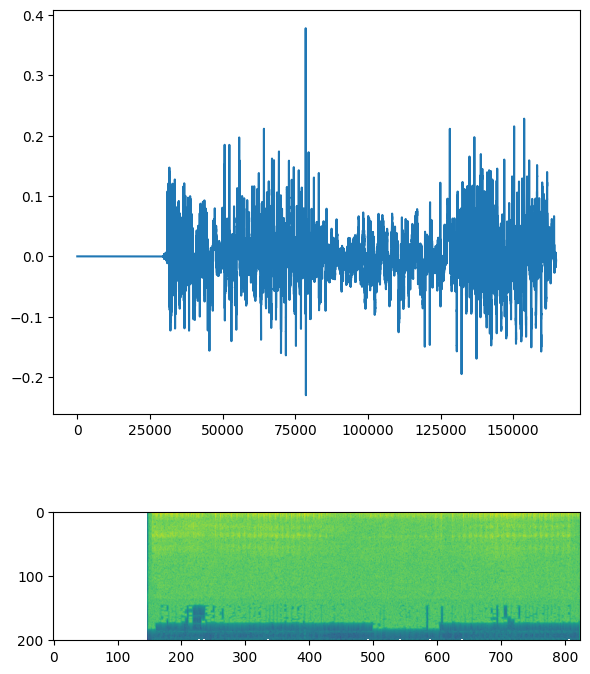

In [ ]:
plot_audio('Purring/cat_coll0133_aug1(1).mp3')

Shape of waveform: torch.Size([2, 40320])
Sample rate of waveform: 44100


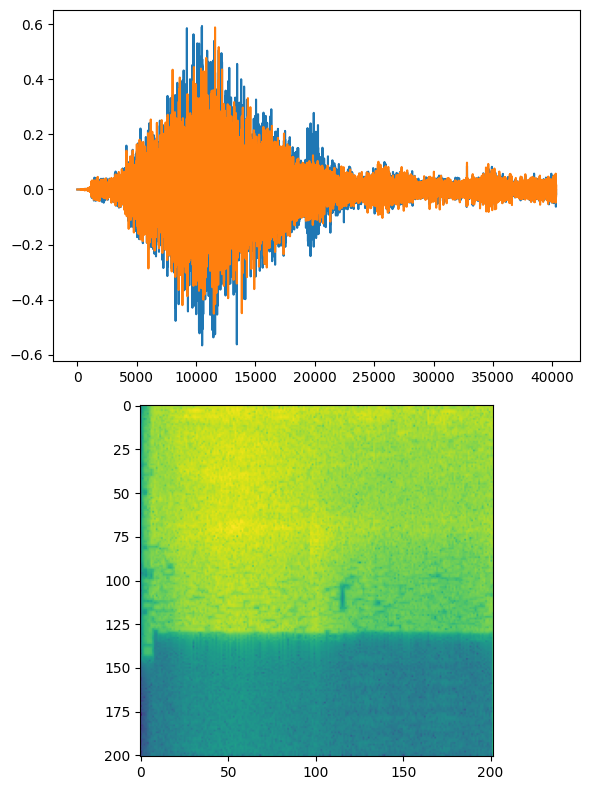

In [ ]:
plot_audio('Hissing/car_extcoll0268.mp3')

Shape of waveform: torch.Size([2, 215424])
Sample rate of waveform: 44100


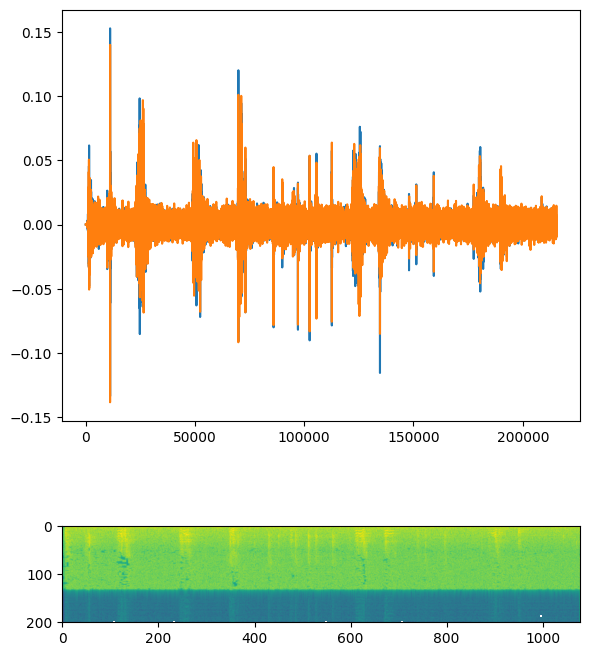

In [ ]:
plot_audio('Chirping/cat_youtube01123.mp3')

# Image dataset

In [ ]:
image_folder_m1 = mfccs_path_model1 if use_mffc else spectrogram_path_model1
image_folder_m2 = mfccs_path_model2 if use_mffc else spectrogram_path_model2

In [ ]:
spec_dataset_m1 = datasets.ImageFolder(
    root=image_folder_m1,
    transform=transforms.Compose([
      transforms.Resize((224,224)),#transforms.Resize((201,81)),
      transforms.ToTensor()
    ])
)
print(spec_dataset_m1)

Dataset ImageFolder
    Number of datapoints: 3161
    Root location: /content/drive/MyDrive/COIN Seminar/data/spectrograms_model1
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [ ]:
spec_dataset_m2 = datasets.ImageFolder(
    root=image_folder_m2,
    transform=transforms.Compose([
      transforms.Resize((201,81)),
      transforms.ToTensor()
    ])
)
print(spec_dataset_m2)

Dataset ImageFolder
    Number of datapoints: 1272
    Root location: /content/drive/MyDrive/COIN Seminar/data/spectrograms_model2
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [ ]:
class_map=spec_dataset_m1.class_to_idx

print("\nClass category and index of the images for model 1: {}\n".format(class_map))


Class category and index of the images for model 1: {'chirp': 0, 'hiss': 1, 'meow': 2, 'purr': 3}



In [ ]:
class_map=spec_dataset_m2.class_to_idx

print("\nClass category and index of the images for model 2: {}\n".format(class_map))


Class category and index of the images for model 2: {'angry': 0, 'happy': 1, 'sad': 2}



In [ ]:
def create_data_split(dataset):
  #split data to test and train
  #use 80% to train
  train_size = int(0.8 * len(dataset))
  test_size = len(dataset) - train_size
  train, test = torch.utils.data.random_split(dataset, [train_size, test_size])

  return train, test

In [ ]:
train_dataset_m1, test_dataset_m1 = create_data_split(spec_dataset_m1)
print("Training size Model 1:", len(train_dataset_m1))
print("Testing size Model 1:",len(test_dataset_m1))

Training size Model 1: 2528
Testing size Model 1: 633


In [ ]:
train_dataset_m2, test_dataset_m2 = create_data_split(spec_dataset_m2)
print("Training size Model 2:", len(train_dataset_m2))
print("Testing size Model 2:",len(test_dataset_m2))

Training size Model 2: 1017
Testing size Model 2: 255


In [ ]:
train_dataloader_m1 = torch.utils.data.DataLoader(
    train_dataset_m1,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader_m1 = torch.utils.data.DataLoader(
    test_dataset_m1,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [ ]:
train_dataloader_m2 = torch.utils.data.DataLoader(
    train_dataset_m2,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader_m2 = torch.utils.data.DataLoader(
    test_dataset_m2,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [ ]:
td = train_dataloader_m1.dataset[0][0][0][0]
print(td)

tensor([0.1294, 0.1255, 0.1686, 0.3373, 0.3098, 0.4627, 0.5020, 0.5412, 0.5137,
        0.6157, 0.6863, 0.6118, 0.5373, 0.5333, 0.5255, 0.5490, 0.5529, 0.5216,
        0.5255, 0.5137, 0.5176, 0.5255, 0.5137, 0.5176, 0.5373, 0.5333, 0.5059,
        0.5059, 0.4706, 0.5333, 0.4471, 0.4863, 0.5098, 0.5412, 0.5176, 0.4980,
        0.3569, 0.4314, 0.5176, 0.5176, 0.5490, 0.5294, 0.5412, 0.5059, 0.4980,
        0.5490, 0.5137, 0.4667, 0.5255, 0.5137, 0.5098, 0.5412, 0.5059, 0.4784,
        0.4784, 0.4941, 0.5020, 0.4196, 0.4588, 0.4745, 0.4431, 0.4980, 0.5451,
        0.5333, 0.5098, 0.4784, 0.5373, 0.5098, 0.4902, 0.4275, 0.4078, 0.3922,
        0.4588, 0.4706, 0.4627, 0.4196, 0.4157, 0.3686, 0.3098, 0.3294, 0.2549])


# Convolutional Neural Network

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Model Architecture

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18_features = nn.Sequential(*(list(resnet18.children())[:-2]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class CNNet(nn.Module):
    def __init__(self, n_output):
        super().__init__()
        #self.resnet = resnet18_features
        #self.conv1 = nn.Conv2d(512, 32, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, n_output)


    def forward(self, x):
        #x = self.resnet(x)

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))

        return F.log_softmax(x,dim=1)


## Train and Test functions

In [ ]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0005

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):

        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

## Train and evaluate model

In [ ]:
model = CNNet(4).to(device)

In [ ]:
epochs = 15

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader_m1, model, cost, optimizer)
    test(test_dataloader_m1, model)
print('Done!')

Epoch 1
-------------------------------
loss: 1.377650  [    0/ 2528]
loss: 1.188947  [ 1500/ 2528]

Test Error:
acc: 46.8%, avg loss: 0.082406

Epoch 2
-------------------------------
loss: 1.023261  [    0/ 2528]
loss: 0.903006  [ 1500/ 2528]

Test Error:
acc: 53.4%, avg loss: 0.070965

Epoch 3
-------------------------------
loss: 0.755890  [    0/ 2528]
loss: 1.056490  [ 1500/ 2528]

Test Error:
acc: 47.9%, avg loss: 0.075818

Epoch 4
-------------------------------
loss: 0.763137  [    0/ 2528]
loss: 1.126359  [ 1500/ 2528]

Test Error:
acc: 48.2%, avg loss: 0.127868

Epoch 5
-------------------------------
loss: 0.689451  [    0/ 2528]
loss: 0.718410  [ 1500/ 2528]

Test Error:
acc: 62.7%, avg loss: 0.057156

Epoch 6
-------------------------------
loss: 0.779546  [    0/ 2528]
loss: 0.838623  [ 1500/ 2528]

Test Error:
acc: 61.0%, avg loss: 0.062623

Epoch 7
-------------------------------
loss: 0.779567  [    0/ 2528]
loss: 0.582329  [ 1500/ 2528]

Test Error:
acc: 58.0%, avg l

FileNotFoundError: ignored

In [ ]:
date = time.ctime(time.time())
torch.save(model.state_dict(), f'{notebook_path}/model1_h{epochs}_{date}.pth')

In [ ]:
model2 = CNNet(3).to(device)

In [ ]:
epochs = 15

optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader_m2, model2, cost, optimizer)
    test(test_dataloader_m2, model2)
print('Done!')

Epoch 1
-------------------------------
loss: 1.104062  [    0/ 1017]

Test Error:
acc: 53.3%, avg loss: 0.064638

Epoch 2
-------------------------------
loss: 0.937860  [    0/ 1017]

Test Error:
acc: 53.7%, avg loss: 0.065117

Epoch 3
-------------------------------
loss: 0.976397  [    0/ 1017]

Test Error:
acc: 66.7%, avg loss: 0.051815

Epoch 4
-------------------------------
loss: 0.962296  [    0/ 1017]

Test Error:
acc: 78.0%, avg loss: 0.044340

Epoch 5
-------------------------------
loss: 0.591651  [    0/ 1017]

Test Error:
acc: 78.0%, avg loss: 0.036951

Epoch 6
-------------------------------
loss: 0.617205  [    0/ 1017]

Test Error:
acc: 78.0%, avg loss: 0.042482

Epoch 7
-------------------------------
loss: 0.609885  [    0/ 1017]

Test Error:
acc: 79.6%, avg loss: 0.034217

Epoch 8
-------------------------------
loss: 0.756121  [    0/ 1017]

Test Error:
acc: 81.2%, avg loss: 0.035840

Epoch 9
-------------------------------
loss: 0.583032  [    0/ 1017]

Test Erro

In [ ]:
date = time.ctime(time.time())
torch.save(model2.state_dict(), f'{notebook_path}/model2_h{epochs}_{date}.pth')

# Evaluation

In [ ]:
def build_confusion_matrix(model, dataloader):
  model.eval()  # Set the model to evaluation mode

  # Iterate through the dataset and collect predictions
  y_pred_list = []
  y_true_list = []
  with torch.no_grad():
      for inputs, labels in dataloader:  # replace dataloader with your own
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, y_pred = torch.max(outputs, 1)
          y_pred_list.extend(y_pred.cpu().numpy())
          y_true_list.extend(labels.cpu().numpy())

  # Convert true labels to a numpy array
  y_true = np.array(y_true_list)
  return confusion_matrix(y_true, y_pred_list)


def plot_confusion_matrix(cm, classes):
  plt.figure(figsize=(len(classes), len(classes)))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
confusion_matrix_m1_test = build_confusion_matrix(model, test_dataloader_m1)
plot_confusion_matrix(confusion_matrix_m1_test, ['chirp', 'hiss', 'meow', 'purr'])

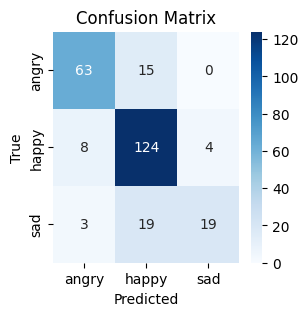

In [ ]:
confusion_matrix_m2_test = build_confusion_matrix(model2, test_dataloader_m2)
plot_confusion_matrix(confusion_matrix_m2_test, ['angry', 'happy', 'sad'])